In [1]:
import matplotlib.pyplot as mpl
import matplotlib
import pandas as pd
import statsmodels.api as sm

In [2]:
# Author Roelof Rietbroek (r.rietbroek@utwente.nl), 2021
import gzip as gz
from frommle2.core.logger import logger
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

cconv=(1-100/60)
swopfac={"E":+1,"W":-1,"N":1,"S":-1}
def parseDeg(deg,EWNS):
    decdeg=deg/60+cconv*int(deg/100)
    return swopfac[EWNS]*decdeg

def smoothDegrees(degarray,timev,irec=0):
        """ Smooths degree array whcih only have degree resolution to a version which varies more smoothly (i.e. no jumps)"""
        
        if len(degarray) == 1:
            #Corner case just return original value
            return degarray


        ddif=np.diff(degarray)

        if np.count_nonzero(ddif) == 0:
            #no need to interpolate in this case as all values are the same
            return degarray

        
        if irec > 1:
            assert("This function is not supposed to be called with a recursion depth more than 1)")
            #Possibly split into contigous sections (i.e. crossing  0-360 border or jumping in time)
        dsections=np.argwhere(np.logical_or((np.abs(ddif) > 180.0), (np.diff(timev) > np.timedelta64(30,'s'))))  
        if dsections.size != 0:
            degsmth=np.full([len(degarray)],np.nan)
            for ist,iend in zip(np.insert(dsections+1,0,0),np.append(dsections+1,len(degarray))):
                #call this function for the sections (it shouldn;t execute this if part)
                degsmth[ist:iend]=smoothDegrees(degarray[ist:iend],timev[ist:iend],irec=irec+1)
        else:
            
            #compute for the contiguous section
            #detect the jumps (and add the first and final index) value
            ijumps=np.insert(np.append(np.argwhere(ddif != 0).squeeze()+1,len(degarray)),0,0)

            #what are half the interval lengths between the jump locations (we need to shift the interpolant input by this)
            iintHalfDistance=np.diff(ijumps)/2
            #create the support points for the interpolant
            isup=ijumps[0:-1]+iintHalfDistance
            degsup=degarray[ijumps[0:-1]]
            inonnan=~np.isnan(degarray[ijumps[0:-1]])
            #create an interpolant based on the values where a jump was detected
            iinterp=interp1d(isup[inonnan],degsup[inonnan],kind='linear',fill_value="extrapolate")
            degsmth=iinterp([float(i) for i in range(len(degarray))])
            

            degsmth[np.isnan(degsmth)]=np.nan #refill original nan values with nans again
        
        return degsmth

def parseGNRMC(ln):
    
    spl=ln.split(",")
    if spl[2] == "V":
        return {}
    hr=int(spl[1][0:2])
    mn=int(spl[1][2:4])
    sec=float(spl[1][4:])
    date=datetime.strptime(spl[9],"%d%m%y")
    dt={"time":date+timedelta(hours=hr,minutes=mn,seconds=sec)}
    #parse weird DDDMM.MMMMM format
    dt["lat"]=parseDeg(float(spl[3]),spl[4])
    dt["lon"]=parseDeg(float(spl[5]),spl[6])
    return dt

def parseGNGSV(ln):
    #split line without considering the checksum at the end
    spl=ln[0:-4].split(",")
    dt={}
    dt["system"]=spl[0][1:3].replace('GL','GLONASS').replace('GP','GPS')
    #loop over available satellite prn's
    for i in range(4,len(spl),4):
        try:
            prn=f"PRN{spl[i]}"
            elev=float(spl[i+1])
            az=float(spl[i+2])
            snr=float(spl[i+3])
        except ValueError:
            #It may be possible that ,,, entries occur, so we'll just ignore those
            continue

        dt[prn]={"elev":elev,"az":az,"snr":snr}
    return dt


dispatchParse={"$GPRMC":parseGNRMC,"$GPGSV":parseGNGSV,"$GNRMC":parseGNRMC,"$GLGSV":parseGNGSV}

def readnmea(fidorfile):
    """Parses a nmea file/stream and puts the output in a pandas dataframe"""
    if type(fidorfile) == str:
        if fidorfile.endswith('.gz'):
            fid=gz.open(fidorfile,'rt')
        else:
            fid=open(fidorfile,'rt')
    else:
        fid=fidorfile



    #loop over the buffer and parse messages as we go
    nmeacycle={}
    nmeadata=[]
    for ln in fid:
        if ln.startswith("$"):
            try:
                nmeacycle.update(dispatchParse[ln[0:6]](ln))

                #possibly append this cycle data to nmeadata when a time tag is present
                if "time" in nmeacycle and (sum(k.startswith("PRN") for k in nmeacycle.keys()) > 0):

                    basedict={k:v for k,v in nmeacycle.items() if not k.startswith("PRN")}

                    #unwrap the different PRN's into separate rows
                    for ky,val in nmeacycle.items():
                        if ky.startswith("PRN"):
                            nmeadata.append({**basedict,"PRN":int(ky[3:]),**val})
                    #reset nmeacycle dict
                    nmeacycle={}
            except KeyError:
                continue
                logger.warning(f"Skipping unknown NMEA message {ln[0:6]}")

    #create a dataframe and set multiindex
    df=pd.DataFrame(nmeadata)
    #We wan to get rid of rows which don;t have a elevation of azimuth in them
    # df.dropna(subset=["elev","az"],inplace=True)
    

    #since the resolution of the elevatio, and azimuthn is only on discrete degrees, let's create smoothed versions (better for plotting etc)
    # Furthermore, we also want to identify the different ascending/descending segment, even/oddly numbered repspectively so we can select of those too
    df["elevsmth"]=np.nan 
    df["azsmth"]=np.nan 
    df["segment"]=-1
    for name,grp in df.groupby("PRN"):
        time=grp.time.to_numpy()
        for dvi,dvo in [("elev","elevsmth"),("az","azsmth")]:
            dsmooth=smoothDegrees(grp[dvi].to_numpy(),time)
            #put the stuff back in the dataframe
            df.loc[grp.index,dvo]=dsmooth


            if dvi == "elev" and len(dsmooth) > 2:
                #also figure out the valid iascending (will be even numbered, descending will be oddly numbered) segments per PRN
                pdif=(np.diff(dsmooth)>0).astype(float)
                segment=np.insert(np.cumsum(np.abs(np.diff(pdif))),0,[0,0]).astype(int)
                if pdif[0] == 0.0:
                    #starts with a descending node
                    #make sure it's oddly numbered
                    segment=segment+1

                df.loc[grp.index,"segment"]=segment


    return df.set_index(["time","system","PRN","segment"])

In [3]:
filename = "2022-03-26-gnssr2.gz"
DF = readnmea(filename)

In [4]:
DF.head(10)

lat       lon  elev     az  \
time                system  PRN segment                                     
2022-03-26 00:00:02 GPS     4   1        52.251285  5.690115  77.0  118.0   
                            9   0        52.251285  5.690115  54.0  214.0   
                            6   0        52.251285  5.690115  53.0  296.0   
                            3   1        52.251285  5.690115  50.0   91.0   
2022-03-26 00:00:03 GLONASS 19  1        52.251285  5.690115  31.0  247.0   
                            49  1        52.251285  5.690115  30.0  180.0   
                            17  1        52.251285  5.690115  22.0  229.0   
                            1   1        52.251285  5.690115  14.0  149.0   
                            31  1        52.251285  5.690115  14.0   34.0   
                            2   0        52.251285  5.690115  11.0  317.0   

                                          snr   elevsmth      azsmth  
time                system  PRN segment                               
2022-03-26 00:00:02 GPS     4   1        34.0  77.603306  118.307692  
                            9   0        32.0  53.888889  213.630189  
                            6   0        33.0  52.480000  296.076923  
                            3   1        36.0  50.500000   90.671429  
2022-03-26 00:00:03 GLONASS 19  1        36.0  31.094340  247.547170  
                            49  1        34.0  30.000000  180.000000  
                            17  1        27.0  22.096154  229.368421  
                            1   1        29.0  14.040000  148.826389  
                            31  1        32.0  14.127273   34.563636  
                            2   0        32.0  10.957447  317.455939

# Dividing Between GPS and GLONASS signals #

In [5]:
DF_GPS = DF.xs('GPS', level='system')
DF_GLONASS = DF.xs('GLONASS', level='system')

### GPS Signals ###

In [6]:
DF_GPS.tail()

lat       lon  elev     az   snr  \
time                PRN segment                                           
2022-03-26 23:59:52 3   11       52.251280  5.690102  49.0   92.0  33.0   
2022-03-26 23:59:57 4   22       52.251282  5.690100  77.0  110.0  27.0   
                    9   12       52.251282  5.690100  56.0  214.0  28.0   
                    6   14       52.251282  5.690100  54.0  294.0  42.0   
                    3   11       52.251282  5.690100  49.0   92.0  37.0   

                                  elevsmth      azsmth  
time                PRN segment                         
2022-03-26 23:59:52 3   11       48.728571   92.271429  
2022-03-26 23:59:57 4   22       77.687764  108.173913  
                    9   12       56.444444  214.356383  
                    6   14       54.285714  293.565217  
                    3   11       48.700000   92.300000

**Filter The Azimuth**

In [7]:
DF_GPSaz = DF_GPS[DF_GPS['azsmth'].between(0, 90, inclusive=False)]
DF_GPSaz

/tmp/ipykernel_609/4165221174.py:1: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  DF_GPSaz = DF_GPS[DF_GPS['azsmth'].between(0, 90, inclusive=False)]


,,,lat,lon,elev,az,snr,elevsmth,azsmth
time,PRN,segment,,,,,,,
2022-03-26 00:15:07,4,1,52.251235,5.690122,74.0,90.0,38.0,74.242105,89.936170
2022-03-26 00:15:12,4,1,52.251235,5.690122,74.0,90.0,38.0,74.221053,89.808511
2022-03-26 00:15:17,4,1,52.251235,5.690120,74.0,90.0,36.0,74.200000,89.680851
2022-03-26 00:15:22,4,1,52.251235,5.690120,74.0,90.0,34.0,74.178947,89.553191
2022-03-26 00:15:27,4,1,52.251235,5.690120,74.0,90.0,34.0,74.157895,89.425532
...,...,...,...,...,...,...,...,...,...
2022-03-26 23:52:47,3,11,52.251265,5.690105,51.0,90.0,36.0,51.208333,89.861111
2022-03-26 23:52:52,3,11,52.251263,5.690105,51.0,90.0,38.0,51.166667,89.888889
2022-03-26 23:52:57,3,11,52.251263,5.690105,51.0,90.0,39.0,51.125000,89.916667


**Filter The Elevation Angle**

In [8]:
DF_GPSel = DF_GPSaz[DF_GPS['elevsmth'].between(40, 80, inclusive=False)]
DF_GPSel

/tmp/ipykernel_609/2616587501.py:1: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  DF_GPSel = DF_GPSaz[DF_GPS['elevsmth'].between(40, 80, inclusive=False)]
/tmp/ipykernel_609/2616587501.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  DF_GPSel = DF_GPSaz[DF_GPS['elevsmth'].between(40, 80, inclusive=False)]


,,,lat,lon,elev,az,snr,elevsmth,azsmth
time,PRN,segment,,,,,,,
2022-03-26 00:15:07,4,1,52.251235,5.690122,74.0,90.0,38.0,74.242105,89.936170
2022-03-26 00:15:12,4,1,52.251235,5.690122,74.0,90.0,38.0,74.221053,89.808511
2022-03-26 00:15:17,4,1,52.251235,5.690120,74.0,90.0,36.0,74.200000,89.680851
2022-03-26 00:15:22,4,1,52.251235,5.690120,74.0,90.0,34.0,74.178947,89.553191
2022-03-26 00:15:27,4,1,52.251235,5.690120,74.0,90.0,34.0,74.157895,89.425532
...,...,...,...,...,...,...,...,...,...
2022-03-26 23:52:47,3,11,52.251265,5.690105,51.0,90.0,36.0,51.208333,89.861111
2022-03-26 23:52:52,3,11,52.251263,5.690105,51.0,90.0,38.0,51.166667,89.888889
2022-03-26 23:52:57,3,11,52.251263,5.690105,51.0,90.0,39.0,51.125000,89.916667


**Get the list of PRN based on the filtered azimuth & Elevation Angle**

In [9]:
DF_GPSp= DF_GPSel.index.get_level_values('PRN')
#print(DF_GPSp)
PRN_Code = []
for code in DF_GPSp:
    if code not in PRN_Code:
        PRN_Code.append(code)
print(PRN_Code)

[4, 9, 7, 30, 14, 19, 12, 25, 29, 18, 23, 10, 32, 22, 3]


segment      4.726209
lat         52.251253
lon          5.690124
elev        55.458630
az          72.771315
snr         36.652021
elevsmth    55.439708
azsmth      72.821979
dtype: float64
time        0 days 07:11:50.423387226
segment                       3.69183
lat                          0.000047
lon                          0.000048
elev                         11.09573
az                           7.995008
snr                          5.571515
elevsmth                    11.112514
azsmth                       7.964716
dtype: object


/tmp/ipykernel_609/2078721980.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(DF_GGG.mean())


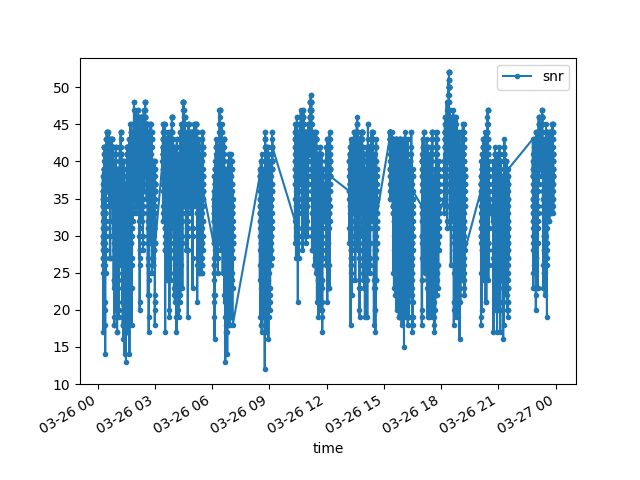

In [10]:
%matplotlib widget
DF_GGG = DF_GPSel.droplevel('PRN', axis=0).reset_index()
DF_GGG.plot(x='time',y='snr',marker='.')
print(DF_GGG.mean())
print(DF_GGG.std())

**PRN 4**

In [11]:
DF_GPSF = DF_GPSel.xs(4,level='PRN')
DF_GPSF

,,lat,lon,elev,az,snr,elevsmth,azsmth
time,segment,,,,,,,
2022-03-26 00:15:07,1,52.251235,5.690122,74.0,90.0,38.0,74.242105,89.936170
2022-03-26 00:15:12,1,52.251235,5.690122,74.0,90.0,38.0,74.221053,89.808511
2022-03-26 00:15:17,1,52.251235,5.690120,74.0,90.0,36.0,74.200000,89.680851
2022-03-26 00:15:22,1,52.251235,5.690120,74.0,90.0,34.0,74.178947,89.553191
2022-03-26 00:15:27,1,52.251235,5.690120,74.0,90.0,34.0,74.157895,89.425532
...,...,...,...,...,...,...,...,...
2022-03-26 01:35:02,1,52.251213,5.690090,41.0,67.0,36.0,40.680851,66.900901
2022-03-26 01:35:07,1,52.251215,5.690087,41.0,67.0,38.0,40.638298,66.906907
2022-03-26 01:35:12,1,52.251215,5.690088,41.0,67.0,40.0,40.595745,66.912913


In [12]:
DF_GPSazmax = DF_GPSF['azsmth'].max()
DF_GPSazmin = DF_GPSF['azsmth'].min()
print(DF_GPSazmin,',', DF_GPSazmax)

DF_GPSelmax = DF_GPSF['elevsmth'].max()
DF_GPSelmin = DF_GPSF['elevsmth'].min()
print(DF_GPSelmin,',', DF_GPSelmax)

65.0 , 89.93617021276596
40.51063829787234 , 74.2421052631579


In [13]:
DF_GPSFValue= DF_GPSF.index.get_level_values('segment')
#print(DF_GPS4Value)
segment = []
for element in DF_GPSFValue:
    if element not in segment:
        segment.append(element)
print(segment)

[1]


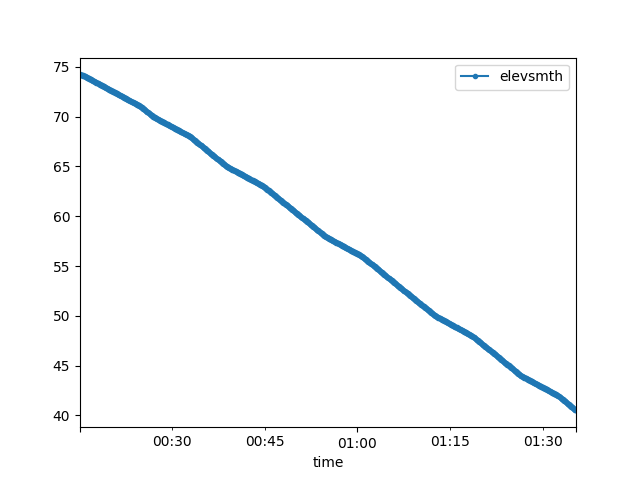

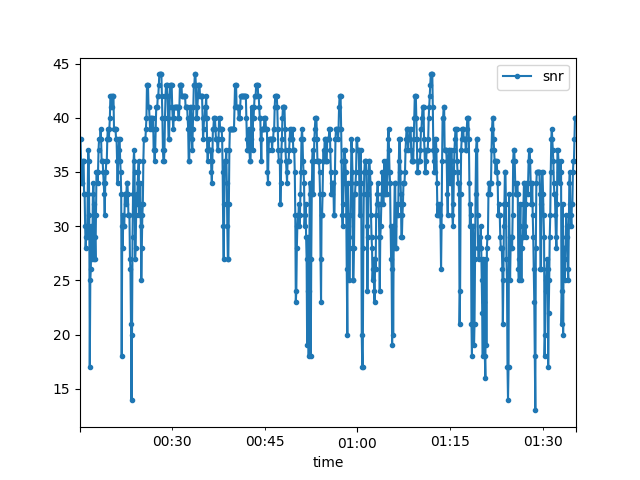

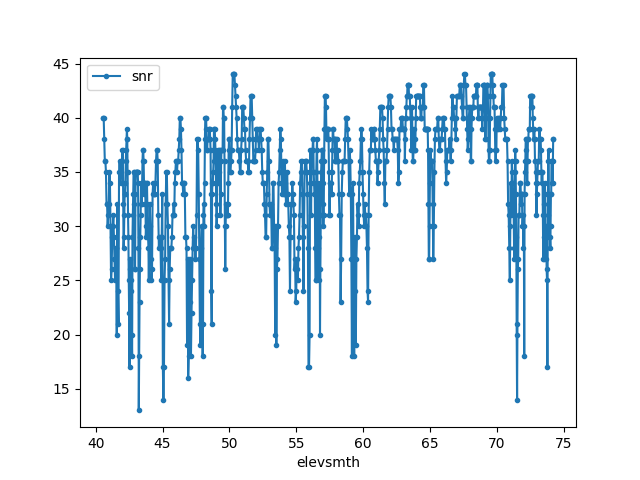

In [14]:
%matplotlib widget
GPSF_segment1=DF_GPSF.xs(1,level='segment').reset_index().plot(x='time',y='elevsmth',marker='.')
GPSF_segment1=DF_GPSF.xs(1,level='segment').reset_index().plot(x='time',y='snr',marker='.')
GPSF_segment1=DF_GPSF.xs(1,level='segment').reset_index().plot(x='elevsmth',y='snr',marker='.')

# GPSF_segment2=DF_GPSF.xs(25,level='segment').reset_index().plot(x='time',y='elevsmth',marker='.')
# GPSF_segment3=DF_GPSF.xs(25,level='segment').reset_index().plot(x='time',y='snr',marker='.')